In [873]:
import numpy as np
import glob
import pickle
from tqdm import tqdm
from collections import defaultdict
import pandas as pd
import seaborn as sns
from ibhelpers import *
from pathlib import Path
import os
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns

In [848]:
paths = glob.glob("lc_data/suboptimal/*.p")
suboptimal_Qs = defaultdict(dict)
for p in tqdm(paths):
    try:
        float(p.split("/")[-1].split(".p")[0].split("_")[0])
    except ValueError:
        continue
    with open(p, "rb") as file:
        a = pickle.load(file)
    suboptimal_Qs[a[0]]["rotation_indices"] = a[1]
    suboptimal_Qs[a[0]]["rate"] = float(p.split("/")[-1].split("_")[0])
    suboptimal_Qs[a[0]]["distortion"] = float(p.split("/")[-1].split("_")[1].split(".p")[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 5681.02it/s]


In [850]:
language_scores_optimal = pd.read_csv("output/language_scores.csv")
optimal_Qs = defaultdict(dict)
for i,row in language_scores_optimal.iterrows():
    optimal_Qs[int(row["language"])]["rate"] = row["rate"]
    optimal_Qs[int(row["language"])]["distortion"] = row["distortion"]

In [851]:
frontier_Qs = defaultdict(dict)
for frontier_q_matrix in tqdm(glob.glob("frontier/q_matrices/*")):
    beta = frontier_q_matrix.split("/")[-1].split("_")[0]
    frontier_Qs[beta]["rate"] = frontier_q_matrix.split("/")[-1].split("_")[1]
    frontier_Qs[beta]["distortion"] = frontier_q_matrix.split("/")[-1].split("_")[2].split(".npy")[0]
    frontier_Qs[beta]["q_joint"] = np.load(frontier_q_matrix)
    frontier_Qs[beta]["q_marginal"] = frontier_Qs[beta]["q_joint"]/frontier_Qs[beta]["q_joint"].sum(1).reshape(-1, 1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:00<00:00, 783.71it/s]


In [852]:
items = []
for score_file in tqdm(glob.glob("lc_data/*/*/*_scores.npy")):
    run_type = score_file.split("/")[1]
    language_id = score_file.split("/")[2]
    iteration = int(score_file.split("/")[3].split("_")[0])
    arr = np.load(score_file)
    means = arr.mean(0)
    rate = means[0]
    distortion = means[1]
    stds = arr.std(0)
    rate_std = stds[0]
    distortion_std = stds[1]
    item = {
        "language_id": language_id,
        "iteration": iteration,
        "rate_avg": rate,
        "distortion_avg": distortion,
        "rate_std": rate_std,
        "distortion_std": distortion_std,
        "run_type": run_type
    }
    items.append(item)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30876/30876 [00:08<00:00, 3515.37it/s]


In [854]:
df = pd.DataFrame(items)

In [860]:
print(df.run_type.unique())
df.head()

['lang' 'ce' 'suboptimal']


,language_id,iteration,rate_avg,distortion_avg,rate_std,distortion_std,run_type
0,61,28000,1.075409e+00,3.882048,5.612922e-02,0.047298,lang
1,61,3,-1.035898e-16,4.773407,1.692666e-16,0.000001,lang
2,61,650,7.435941e-01,4.146470,6.300971e-02,0.057248,lang
3,61,11000,1.067917e+00,3.887028,5.115736e-02,0.045541,lang
4,61,15000,1.070537e+00,3.883785,5.997919e-02,0.050282,lang


In [861]:
frontier = np.load("comm_frontier_points.npy")
frontier1 = np.load("comm_frontier_points3.npy")
frontier2 = np.load("comm_frontier_points4.npy")
frontier = np.concatenate([frontier, frontier1, frontier2], axis=0)
fp_df = pd.DataFrame(frontier, columns=["rate", "distortion"])

lang_df = pd.read_csv("wcs/lang.txt", delimiter="\t", header=None)
languages_dict = {str(i+1): l for i, l in enumerate(lang_df[1].values)}
df["language"] = df.language_id.map(languages_dict)

# Plot

In [892]:
import matplotlib.pyplot as plt

languages = ["Agarabi", "Culina", "Dyimini", "Yucuna"]
lids = [2, 32, 35, 108]
palette_colors = sns.color_palette("tab10")
palette_dict = {l: color for l, color in zip(languages, palette_colors)}

In [893]:
sns.set_context("paper")

### Plot CE for all WCS languages

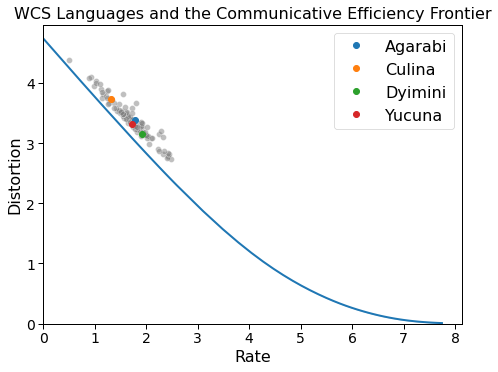

In [894]:
plt.clf()
fig = plt.gcf()
fig.set_size_inches(7.5, 5.5)
plt.ylabel("Distortion", fontsize = 16)
plt.xlabel("Rate", fontsize = 16)
plt.title("WCS Languages and the Communicative Efficiency Frontier", fontsize = 16)
sns.scatterplot(data=language_scores_optimal, x="rate", y="distortion", color="gray", s=35, alpha=0.5)
sns.lineplot(x=fp_df["rate"], y=fp_df["distortion"], linewidth=2)
for lid, language in zip(lids, languages):
    color = palette_dict[language]
    plt.plot(optimal_Qs[lid]["rate"], 
             optimal_Qs[lid]["distortion"], 
             marker="o", 
             markersize=6, 
             color=color, 
             linestyle="None",
             label=language)
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.tick_params(labelsize=14)

plt.legend(fontsize = 16)
plt.savefig("wcs_ce.png", dpi=300)
plt.show()

### Plot SOM learning trajectories

In [895]:
def plot_arrows(ax, df, color):
    coords_mean = df.sort_values("iteration")[["rate_avg", "distortion_avg"]].values
    for i in range(len(coords_mean)):
        if i < coords_mean.shape[0] - 1:
            ax.quiver(
                *coords_mean[:-1].T[:, i],
                *np.diff(coords_mean, axis=0).T[:, i],
                angles="xy",
                scale_units="xy",
                scale=1.1,
                color=color,
            )

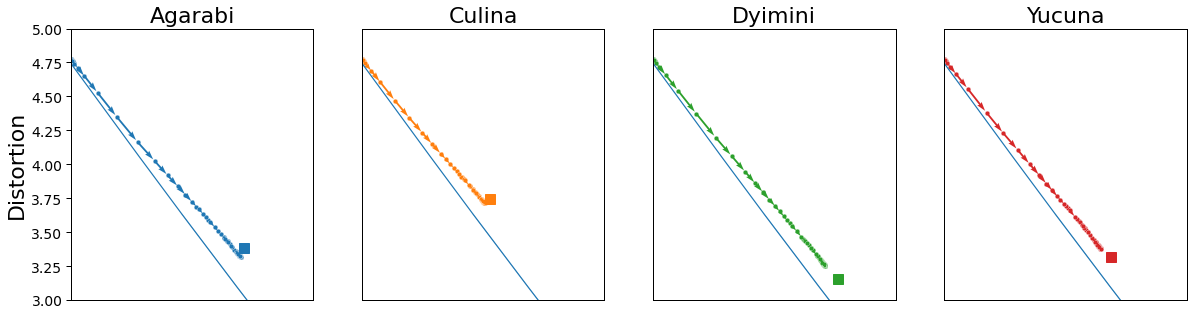

In [1002]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(20, 5)

for i, (lid, language) in enumerate(zip(lids, languages)):
    axes[i].set_xlim(0, 2.5)
    axes[i].set_ylim(3, 5)
    color = palette_dict[language]
    df_selection = (df.language_id==str(lid))&(df.run_type =="lang")
    sns.lineplot(x=fp_df["rate"], y=fp_df["distortion"], ax=axes[i])
    sns.scatterplot(data=df[df_selection], x="rate_avg", y="distortion_avg", color=color, ax=axes[i])
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")
    axes[i].set_title(f"{language}", fontsize = 22)
    plot_arrows(axes[i], df[df_selection], color)
    axes[i].plot(optimal_Qs[lid]["rate"], 
                 optimal_Qs[lid]["distortion"], 
                 marker="s", 
                 linestyle="None",
                 markersize=10, 
                 color=color, 
                 label=language)
    
    axes[i].tick_params(labelsize=14)
    axes[i].set_xticks([])

axes[0].set_ylabel("Distortion", fontsize = 22)
for i in range(1, len(axes)):
    axes[i].set_yticks([])


# handles = []
# labels = []
# for ax in axes:
#     handle, label = ax.get_legend_handles_labels()
#     handles += handle
#     labels += label
    
# fig.legend(handles, labels, loc='right', facecolor='white', framealpha=1, fontsize = 16)
# plt.tight_layout()

# from matplotlib.lines import Line2D
# legend_elements = [Line2D([0], [0], color='w', marker='s', label='Original',markerfacecolor='gray', markersize=10)]

# plt.tight_layout()
# fig.legend(handles=legend_elements, loc='center right', facecolor='white', framealpha=1, fontsize = 16)

plt.savefig("som_lang.png", dpi=300)
plt.show()

### SOM SubOptimal 

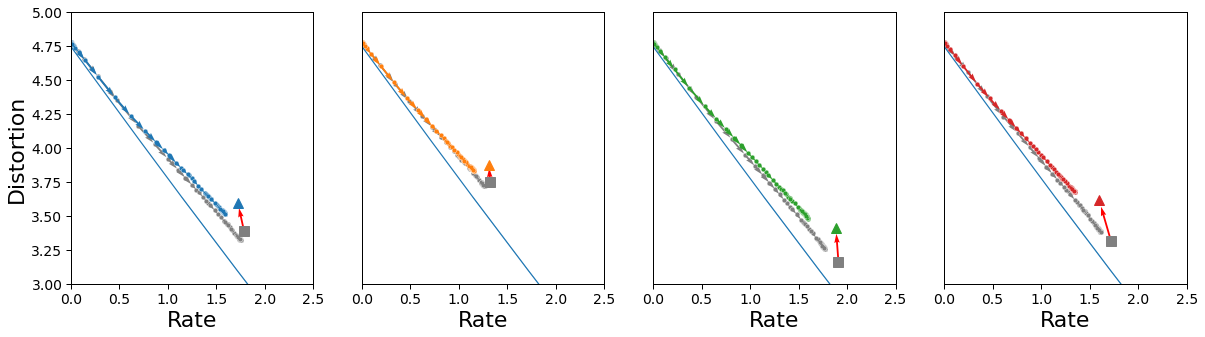

In [1003]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(20, 5)

for i, (lid, language) in enumerate(zip(lids, languages)):
    axes[i].set_xlim(0, 2.5)
    axes[i].set_ylim(3, 5)

    axes[i].set_title("")
    axes[i].set_xlabel("Rate", fontsize = 22)
    color = palette_dict[language]
    df_selection = (df.language_id==str(lid))&(df.run_type =="lang")
    sns.lineplot(x=fp_df["rate"], y=fp_df["distortion"], ax=axes[i])
    sns.scatterplot(data=df[df_selection], x="rate_avg", y="distortion_avg", color="gray", ax=axes[i])
    plot_arrows(axes[i], df[df_selection], "gray")
    axes[i].plot(optimal_Qs[lid]["rate"], 
                 optimal_Qs[lid]["distortion"], 
                 marker="s", 
                 linestyle="None",
                 markersize=10, 
                 color="gray")
    df_selection = (df.language_id==str(lid))&(df.run_type =="suboptimal")
    sns.scatterplot(data=df[df_selection], x="rate_avg", y="distortion_avg", color=color, ax=axes[i])
    plot_arrows(axes[i], df[df_selection], color)
    axes[i].quiver(
                optimal_Qs[lid]["rate"],
                optimal_Qs[lid]["distortion"],
                suboptimal_Qs[lid]["rate"]-optimal_Qs[lid]["rate"],
                suboptimal_Qs[lid]["distortion"]-optimal_Qs[lid]["distortion"],
                color='red',
                angles="xy",
                scale_units="xy",
                scale=1.2,
            )
    axes[i].plot(suboptimal_Qs[lid]["rate"], 
             suboptimal_Qs[lid]["distortion"], 
             marker="^", 
             linestyle="None",
             markersize=10, 
             color=color, 
             label=language)
    axes[i].set_ylabel("")
    axes[i].tick_params(labelsize=14)
    
axes[0].set_ylabel("Distortion", fontsize = 22)
for i in range(1, len(axes)):
    axes[i].set_yticks([])


# handles = []
# labels = []
# for ax in axes:
#     handle, label = ax.get_legend_handles_labels()
#     handles += handle
#     labels += label


# legend_elements = [Line2D([0], [0], color='w', marker='s', label='Original',markerfacecolor='gray', markersize=10), 
#                    Line2D([0], [0], color='w', marker='^', label='Hypothetical',markerfacecolor='gray', markersize=10)]
# fig.legend(handles=legend_elements, loc='center right', facecolor='white', framealpha=1, fontsize = 16)
plt.savefig("som_lang_suboptimal.png", dpi=300)
plt.show()

### Frontier Plots

In [939]:
df[df.run_type=="ce"].sort_values("language_id").language_id.unique()

array(['1.0', '1.0942937012608183', '1.1974787046190125',
       '1.2226402776921537', '1.2570133745219152', '1.3013418554420224',
       '1.3660402567544874', '1.4439291955225915', '1.494849248635036',
       '1.591072967509939', '1.7171308728756145', '1.9453098948246872',
       '11.47164198412687', '11.79415373832906', '15.562479158596808',
       '16.336194011315325', '2.084931521682364', '2.3133763678107044',
       '2.445280555384271', '2.6758551095723657', '21.406840876577977',
       '28.442965797330316', '29.446004819996055', '3.160165247453665',
       '3.3869812494502707', '3.5064228852643056', '31.5594465437875',
       '5.464161027017788', '5.617779502952197', '7.361501204999231',
       '8.11167583832047', '9.382679593855276'], dtype=object)

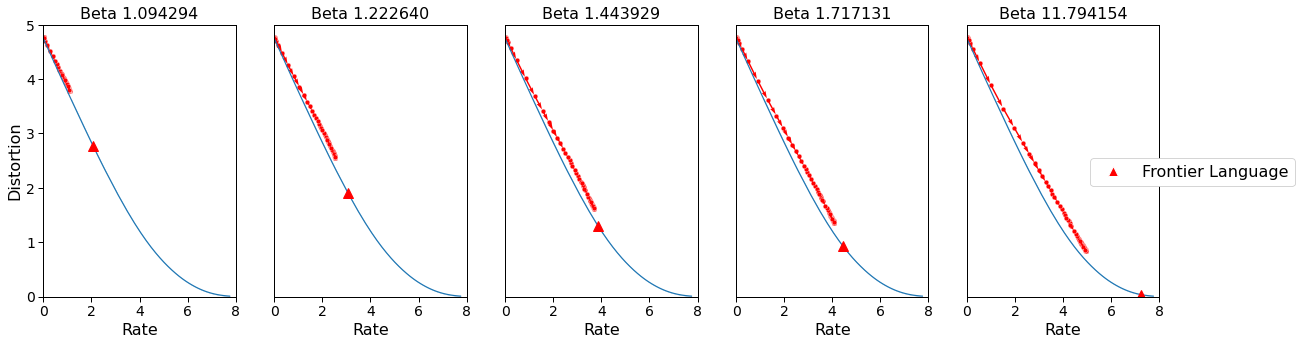

In [1004]:
betas = ['1.0942937012608183', '1.2226402776921537', '1.4439291955225915', '1.7171308728756145', '11.79415373832906']

fig, axes = plt.subplots(1, len(betas), figsize=(20,5))
for i, beta in enumerate(betas):
    ax = axes[i]
    df_selection = (df.language_id==beta)&(df.run_type =="ce")
    sns.lineplot(x=fp_df["rate"], y=fp_df["distortion"], ax=ax)
    sns.scatterplot(data=df[df_selection], x="rate_avg", y="distortion_avg", color="red", ax=ax)

    ax.set_xlabel("Rate", fontsize=16)
    ax.set_title(f"Beta {float(beta):.6f}", fontsize=16)
    plot_arrows(ax, df[df_selection], "red")
    
    ax.plot(float(frontier_Qs[beta]["rate"]), 
            float(frontier_Qs[beta]["distortion"]), 
            marker="^", 
            linestyle="None",
            markersize=10, 
            color='red')

    ax.set_xlim(0, 8)
    ax.set_ylim(0, 5)
    ax.tick_params(labelsize=14)
    
    if i == 0:
        ax.set_ylabel("Distortion", fontsize=16)
    else:
        ax.set_ylabel("")
        ax.set_yticks([])

legend_elements = [Line2D([0], [0], color='w', marker='^', label='Frontier Language',markerfacecolor='red', markersize=10)]
fig.legend(handles=legend_elements, loc='center right', facecolor='white', framealpha=1, fontsize = 16)
plt.savefig("som_lang_frontier.png", dpi=300)
plt.show()

# Convergence Plots

In [989]:
def get_q_for_language(language_id: int):
    df = pd.read_csv("wcs/term.txt", delimiter="\t", header=None)
    df.columns = ["language", "speaker", "chip", "word"]
    df = df[df.language == language_id].copy()
    per_chip_count_df = df.groupby(["chip", "word"]).speaker.agg(individual_count_per_word_per_chip="count")
    total_word_count_df = df.groupby(["chip"]).chip.agg(total_words_per_chip="count")
    p_word_chip_language = per_chip_count_df["individual_count_per_word_per_chip"] / total_word_count_df["total_words_per_chip"]
    language_df = p_word_chip_language.reset_index()

    words = language_df.word.unique()
    words.sort()
    language_df.word = language_df.word.map({word: i for i, word in enumerate(words)})
    q = np.zeros((330, language_df.word.nunique()))
    
    p_c = ((df.chip-1).value_counts() / len(df)).sort_index().values.reshape(-1, 1)

    for i, row in language_df.iterrows():
        q[int(row["chip"])-1][int(row["word"])] = row[0]
    return q, p_c

In [990]:
# Generating source.npy files for all types of languages
for frontier_folder in tqdm(glob.glob("lc_data/ce/*")):
    beta = frontier_folder.split("/")[-1]
    source = frontier_Qs[beta]["q_marginal"]
    # np.save(frontier_folder+"/source.npy", source)
    np.save("sources"+f"/frontier_{beta}_source.npy", source)
    
for suboptimal_folder in tqdm(glob.glob("lc_data/suboptimal/*")):
    try:
        language_id = int(suboptimal_folder.split("/")[-1])    
        if not os.path.isdir(suboptimal_folder):
            continue
    except ValueError:
        continue

    rotation_indices = suboptimal_Qs[language_id]["rotation_indices"]
    q, _ = get_q_for_language(language_id)
    source = q[rotation_indices]
    # np.save(suboptimal_folder+"/source.npy", source)
    np.save("sources"+f"/suboptimal_{language_id}_source.npy", source)
    
for lang_folder in tqdm(glob.glob("lc_data/lang/*")):
    try:
        language_id = int(lang_folder.split("/")[-1])
    except ValueError:
        continue
    source, _ = get_q_for_language(language_id)
    np.save("sources"+f"/lang_{language_id}_source.npy", source)
    # np.save(lang_folder+"/source.npy", source)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:18<00:00,  5.98it/s]


In [877]:
# Use convergence.py to generate pkl files with accuracies and convergence metrics
accuracies = pickle.load(open("accuracies.pkl", "rb"))
lid_conv = pickle.load(open("n_conv.pkl", "rb"))

In [878]:
lids = []
accuracy_df = []
n_samples = []
for lid, acc_dict in accuracies.items():
    for n, accs in acc_dict.items():
        accuracy_df += accs
        lids += [lid] * len(accs)
        n_samples += [n] * len(accs)
        
results = pd.DataFrame({"n_samples": n_samples, "language": lids, "accuracy": accuracy_df})
results["run_type"] = results.language.apply(lambda x : x.split("_")[0])
results["language_id"] = results.language.apply(lambda x : x.split("_")[1])

In [986]:
data = []
for k, v in lid_conv.items():
    for c in v:
         data.append({"language": k, "convergence": c})
convergence_df = pd.DataFrame(data)
convergence_df["run_type"] = convergence_df.language.apply(lambda x : x.split("_")[0])
convergence_df["language_id"] = convergence_df.language.apply(lambda x : x.split("_")[1])
convergence_df["convergence"] = convergence_df["convergence"]
convergence_df["run_type"] = convergence_df["run_type"].map({"ce": "Frontier Languages", "lang": "WCS Languages", "suboptimal": "Hypothetical Languages"})

[]

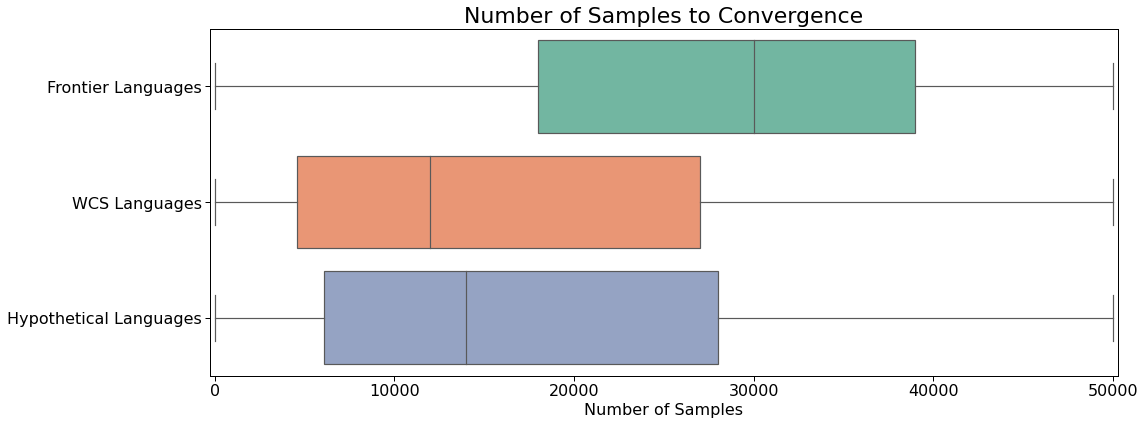

In [997]:
fig = plt.gcf()
plt.xlim(-250, 50250)
fig.set_size_inches(16, 6)
sns.boxplot(data=convergence_df, x="convergence", y="run_type", palette=sns.color_palette("Set2"))
plt.title("Number of Samples to Convergence", fontsize=22)
plt.xlabel("Number of Samples", fontsize=16)
plt.ylabel("")
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("agg_convergence.png", dpi=300)
plt.plot()

In [974]:
from scipy.stats import ttest_ind
a = convergence_df[convergence_df.run_type == "Hypothetical Languages"].convergence.values
b = convergence_df[convergence_df.run_type == "WCS Languages"].convergence.values
ttest_ind(a, b)

Ttest_indResult(statistic=4.807273052870237, pvalue=1.550199147411482e-06)

In [ ]:
for lid, cn in lid_conv.items():
    plt.clf()
    fig, axes = plt.subplots(2, 1, figsize=(10,6))
    axes[0].set_ylim(0, 1)
    axes[0].set_xlim(0, 50000)
    axes[0].set_xticks([])
    sns.lineplot(x="n_samples", y="accuracy", hue="language", data=results[results.language == lid], ax=axes[0])
    axes[0].get_legend().remove()
    axes[0].set_title(lid, fontsize=16)
    axes[0].axvline(np.median(lid_conv[lid]), linestyle="--", color="blue")
    axes[0].axvline(np.mean(lid_conv[lid]), linestyle="--", color="red")
    sns.boxplot(x=lid_conv[lid], ax=axes[1])
    axes[1].set_xlim(10000, 12000)
    plt.show()